Assignment 6 <br>
Name : Summan Bahadur <br>
Roll Number : MSDSF21M509 <br>


In this work I classify images of sign language letters with convolutional network using PyTorch. 

First, let's import everything we need for work: 

In [16]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [17]:

data_raw = pd.read_csv('./datasets/sign_mnist_train.csv', sep=",")
test_data_raw = pd.read_csv('./datasets/sign_mnist_test.csv', sep=",")

labels = data_raw['label']
data_raw.drop('label', axis=1, inplace=True)
labels_test = test_data_raw['label']
test_data_raw.drop('label', axis=1, inplace=True)

data = data_raw.values
labels = labels.values
test_data = test_data_raw.values
labels_test = labels_test.values


Before we go on, let's take a peek at the data we're dealing with:

<AxesSubplot:>

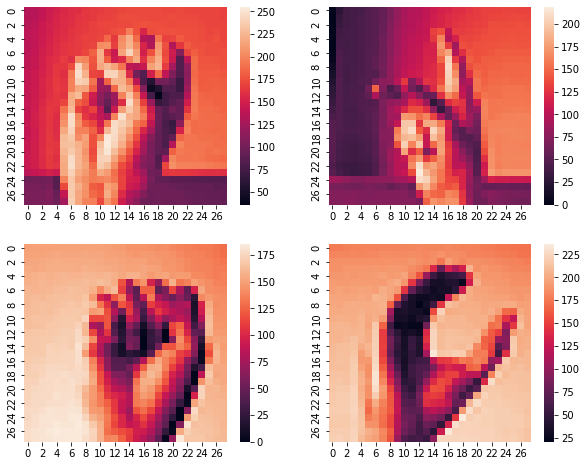

In [18]:
plt.figure(figsize=(10, 8))

pixels = data[10].reshape(28, 28)
plt.subplot(221)
sns.heatmap(data=pixels)

pixels = data[11].reshape(28, 28)
plt.subplot(222)
sns.heatmap(data=pixels)

pixels = data[20].reshape(28, 28)
plt.subplot(223)
sns.heatmap(data=pixels)

pixels = data[32].reshape(28, 28)
plt.subplot(224)
sns.heatmap(data=pixels)

In [19]:
pixels.shape

(28, 28)

I've created the alphabet dictionary just so I can check the output more easily. That way we can see the actual letter instead of the numeric label representation. 

In [20]:
import string

alph = {0:'a', 1:'b', 2:'c', 3:'d', 4:'e', 5:"f", 6:'g', 7:'h', 8:'i', 9:'j', 10:'k', 11:'l', 12:'m', 13:'n',
        14:'o', 15:'p', 16:'q', 17:'r', 18:'s', 19:'t', 20:'u', 21:'v', 22:'w', 23:'x', 24:'y', 25:'z'}

The  dataset consists of 1D arrays for each image. If we want it to work correctly with CNN, we will need to reshape it into 2D format. In this specific case, we have 28\*28 images.

I've created a primive function that gets the job done, it takes the dataset and dimention of images, and returnes the reshaped dataset:

In [21]:
def reshape_to_2d(data, dim):
    reshaped = []
    for i in data:
        reshaped.append(i.reshape(1, dim, dim))

    return np.array(reshaped)

Now we can apply it to the dataset, then divide it into features (x) and labels (y), and construct Tensors.

In [22]:
data = reshape_to_2d(data, 28)

x = torch.FloatTensor(data)
y = torch.LongTensor(labels.tolist())

test_labels = torch.LongTensor(labels_test.tolist())

test_data_formated = reshape_to_2d(test_data, 28)
test_data_formated = torch.FloatTensor(test_data_formated)

Next, we need to define the hyperparameters. 

In [23]:
epochs = 50
batch_size = 100
learning_rate = 0.001

Now we define the architecture of the network. As mentioned before, I will be using a basic CNN. I've stopped at 3 conv. layers with maxpool at first two. I've also added a [dropout](https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/dropout_layer.html) after the third conv. layer, which helps with overfitting and is generally nice to have.
I've also added two custom functions: test and evaluate. Both of them just give feedback about performance of the network. *Test* function compares the number of correct predictions and prints the accuracy, while *evaluate* calculates the accuracy and returns it, which is used for logging while training. 

In [24]:
class Network(nn.Module): 
    
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 3)
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(10, 20, 3)
        self.pool2 = nn.MaxPool2d(2)
        
        self.conv3 = nn.Conv2d(20, 30, 3) 
        self.dropout1 = nn.Dropout2d()
        
        self.fc3 = nn.Linear(30 * 3 * 3, 270) 
        self.fc4 = nn.Linear(270, 26) 
        
        self.softmax = nn.LogSoftmax(dim=1)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout1(x) #without dropout accuracy was 75%
                
        x = x.view(-1, 30 * 3 * 3) 
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        
        return self.softmax(x)
    
    
    def test(self, predictions, labels):
        
        self.eval()
        correct = 0
        for p, l in zip(predictions, labels):
            if p == l:
                correct += 1
        
        acc = correct / len(predictions)
        print("Correct predictions: %5d / %5d (%5f)" % (correct, len(predictions), acc))
        
    
    def evaluate(self, predictions, labels):
                
        correct = 0
        for p, l in zip(predictions, labels):
            if p == l:
                correct += 1
        
        acc = correct / len(predictions)
        return(acc)

After the network architecture is designed and defined, we need to create an instance of it. We can "print" the network to take a look at the structure one more time and to make sure everything is fine. 

In [25]:
net = Network()
print(net)

Network(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.5, inplace=False)
  (fc3): Linear(in_features=270, out_features=270, bias=True)
  (fc4): Linear(in_features=270, out_features=26, bias=True)
  (softmax): LogSoftmax(dim=1)
)


To enable the network to learn, we also need to define the optimizer and the loss function. I've tried many optimizers, but SGD with momentum seems to work best for me. But I suggest you experimenting with other optimizers, like Adam or Adadelta. 

Also, keep in mind that different optimizers work differently with learning rates. While one learning rate might be perfect for Adam, it migth stop network form learning with SGD.

In [26]:
optimizer = optim.SGD(net.parameters(), learning_rate, momentum=0.7)
loss_func = nn.CrossEntropyLoss()

I've also created two lists for loss and accuracy just for logging. They will come in handy after the training to see what happened and how the performance has been changing over the training process. 

In [27]:
loss_log = []
acc_log = []

for e in range(epochs):
    for i in range(0, x.shape[0], batch_size):
        x_mini = x[i:i + batch_size] 
        y_mini = y[i:i + batch_size] 
        
        optimizer.zero_grad()
        net_out = net(Variable(x_mini))
        
        loss = loss_func(net_out, Variable(y_mini))
        loss.backward()
        optimizer.step()
        
        if i % 1000 == 0:
            #pred = net(Variable(test_data_formated))
            loss_log.append(loss.item())
            acc_log.append(net.evaluate(torch.max(net(Variable(test_data_formated[:500])).data, 1)[1], 
                                        test_labels[:500]))
        
    print('Epoch: {} - Loss: {:.6f}'.format(e + 1, loss.item()))

Epoch: 1 - Loss: 3.047866
Epoch: 2 - Loss: 1.955454
Epoch: 3 - Loss: 1.116778
Epoch: 4 - Loss: 0.640220
Epoch: 5 - Loss: 0.518650
Epoch: 6 - Loss: 0.589708
Epoch: 7 - Loss: 0.573940
Epoch: 8 - Loss: 0.381869
Epoch: 9 - Loss: 0.241692
Epoch: 10 - Loss: 0.432264
Epoch: 11 - Loss: 0.191797
Epoch: 12 - Loss: 0.181965
Epoch: 13 - Loss: 0.098883
Epoch: 14 - Loss: 0.097470
Epoch: 15 - Loss: 0.109084
Epoch: 16 - Loss: 0.241047
Epoch: 17 - Loss: 0.063587
Epoch: 18 - Loss: 0.089982
Epoch: 19 - Loss: 0.088960
Epoch: 20 - Loss: 0.072152
Epoch: 21 - Loss: 0.038451
Epoch: 22 - Loss: 0.230577
Epoch: 23 - Loss: 0.073292
Epoch: 24 - Loss: 0.183814
Epoch: 25 - Loss: 0.023181
Epoch: 26 - Loss: 0.187417
Epoch: 27 - Loss: 0.053657
Epoch: 28 - Loss: 0.127915
Epoch: 29 - Loss: 0.105021
Epoch: 30 - Loss: 0.013682
Epoch: 31 - Loss: 0.045426
Epoch: 32 - Loss: 0.057290
Epoch: 33 - Loss: 0.027797
Epoch: 34 - Loss: 0.058539
Epoch: 35 - Loss: 0.105206
Epoch: 36 - Loss: 0.072703
Epoch: 37 - Loss: 0.050095
Epoch: 38 

Now the network is trained, and we can take a look at the performance of the network. Blue line represents the loss function, and the orange one represents the accuracy. The data comes from the logs I've defined before.

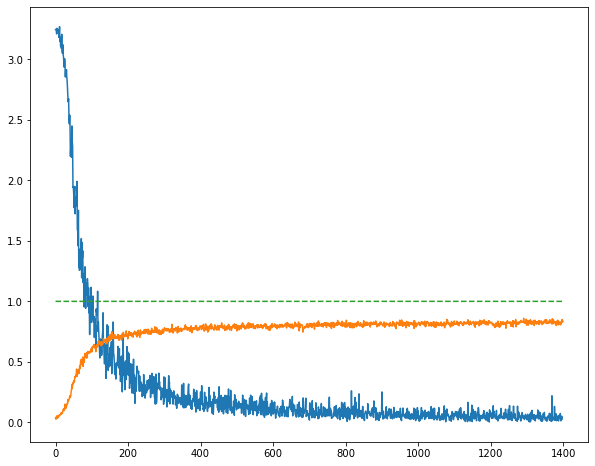

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,8))
plt.plot(loss_log[2:])
plt.plot(acc_log)
plt.plot(np.ones(len(acc_log)), linestyle='dashed')

We can also take a look at some data samples and compare the image with prediction of the network. 

Prediction: h
Actual Label: h
Prediction: i
Actual Label: i
Prediction: i
Actual Label: i
Prediction: v
Actual Label: v


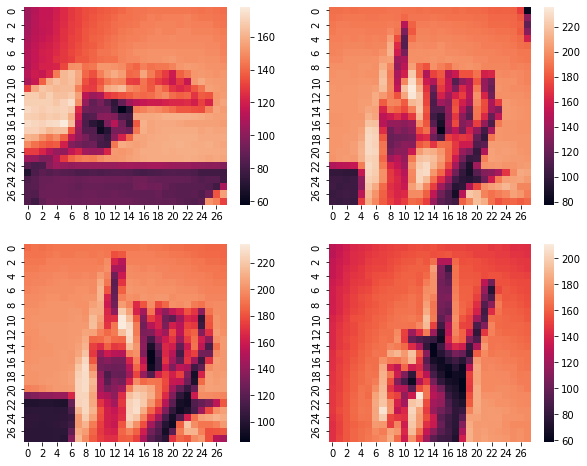

In [29]:
plt.figure(figsize=(10, 8))

sample = 30
pixels = test_data[sample].reshape(28, 28)
plt.subplot(221)
sns.heatmap(data=pixels)
lab = labels_test[sample]
test_sample = torch.FloatTensor([test_data[sample].reshape(1, 28, 28).tolist()])
test_var_sample = Variable(test_sample)
net_out_sample = net(test_var_sample)

print("Prediction: {}".format(alph[torch.max(net_out_sample.data, 1)[1].numpy()[0]]))
print("Actual Label: {}".format(alph[lab]))

sample = 42
pixels = test_data[sample].reshape(28, 28)
plt.subplot(222)
sns.heatmap(data=pixels)
lab = labels_test[sample]
test_sample = torch.FloatTensor([test_data[sample].reshape(1, 28, 28).tolist()])
test_var_sample = Variable(test_sample)
net_out_sample = net(test_var_sample)

print("Prediction: {}".format(alph[torch.max(net_out_sample.data, 1)[1].numpy()[0]]))
print("Actual Label: {}".format(alph[lab]))

sample = 100
pixels = test_data[sample].reshape(28, 28)
plt.subplot(223)
sns.heatmap(data=pixels)
lab = labels_test[sample]
test_sample = torch.FloatTensor([test_data[sample].reshape(1, 28, 28).tolist()])
test_var_sample = Variable(test_sample)
net_out_sample = net(test_var_sample)

print("Prediction: {}".format(alph[torch.max(net_out_sample.data, 1)[1].numpy()[0]]))
print("Actual Label: {}".format(alph[lab]))

sample = 22
pixels = test_data[sample].reshape(28, 28)
plt.subplot(224)
sns.heatmap(data=pixels)
lab = labels_test[sample]
test_sample = torch.FloatTensor([test_data[sample].reshape(1, 28, 28).tolist()])
test_var_sample = Variable(test_sample)
net_out_sample = net(test_var_sample)

print("Prediction: {}".format(alph[torch.max(net_out_sample.data, 1)[1].numpy()[0]]))
print("Actual Label: {}".format(alph[lab]))

And here is the performance in numbers and accuracy:

In [30]:
predictions = net(Variable(test_data_formated))
net.test(torch.max(predictions.data, 1)[1], test_labels)

Correct predictions:  5983 /  7172 (0.834216)
